## 루브릭 평가 기준

### ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

불록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

### 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.

### Ablation Study 결과가 바른 포맷으로 제출되었는가?

ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

In [1]:
# TensorFlow and tf.keras 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 1. ResNet 기본 블록 구성하기

ResNet구조에서 conv_block = Conv layer + BN layer + ReLU가 하나의 쌓으로 구성이 되어있고 이를 통해 block 한 개를 만든다.

In [3]:
def conv_block(input_layer,
              channel,
              kernel_size,
              strides=1,
              activation='relu'):
    x = keras.layers.Conv2D(filters=channel,
                           kernel_size=kernel_size,
                           padding='same',
                           strides=strides)(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
        
    return x

### Step 2. ResNet-34, ResNet-50 Complete Model



ResNet-34와 ResNet-50은 둘 다 conv_block라고 불리는 구조를 3, 4 , 6 ,3 개씩 반복하여 쌓은 상태이지만 둘의 블록 내부 구성은 다릅니다. 

ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, 

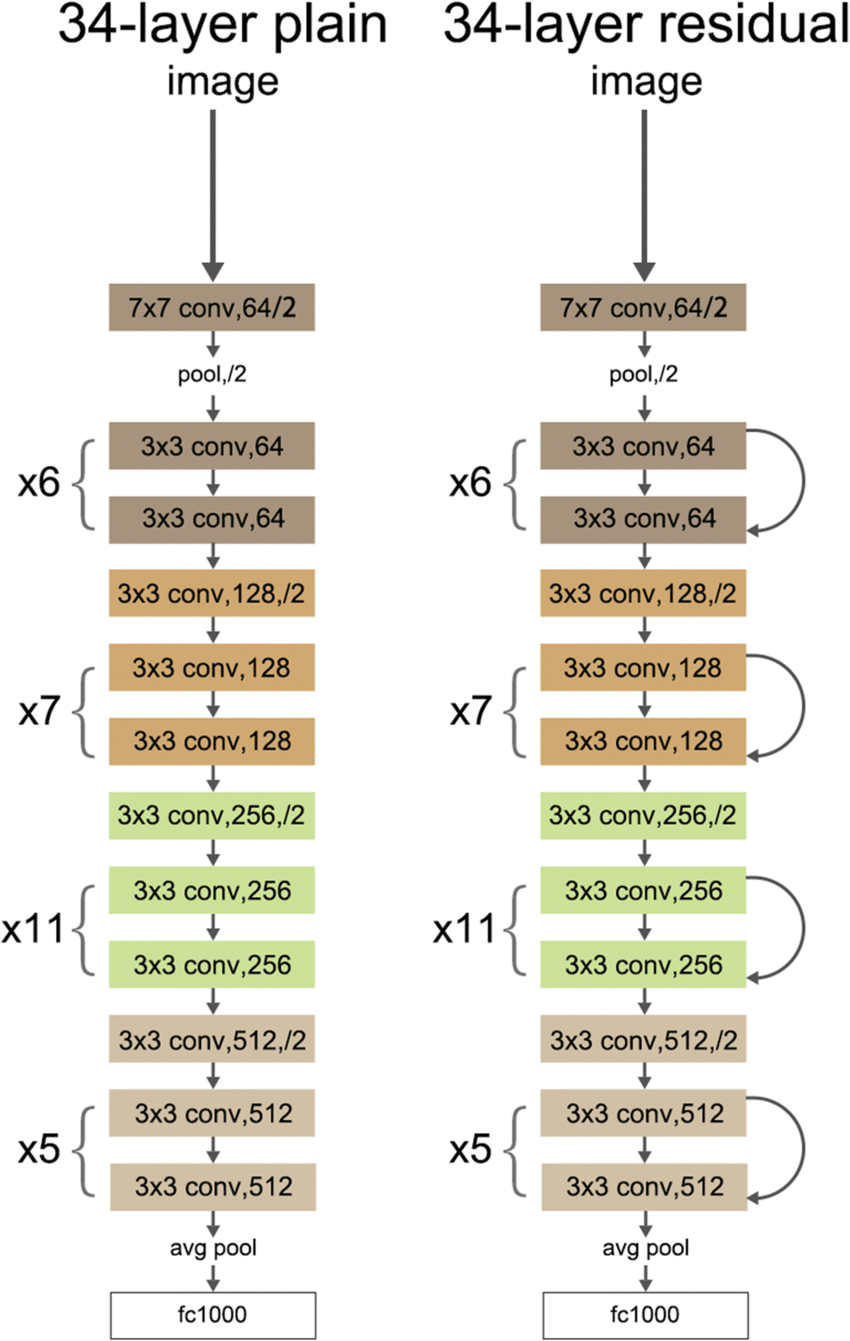


ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [4]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=0,
                   is_50=True):
    
    # 입력 레이어
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    return x

### 코드 뜯어보기

- Pooling layer이후, 3개의 conv_block이 반복될 때 변화

   - output은 마지막 conv_block에서 channel * 4 갖는다.
   


- kernel_size의 변화

    - 첫 conv_block = (1x1)
    
    - 두번째 conv_block = (3x3)
    
    - 마지막 conv_block = (1x1)



- Activation Function 변화

   - 첫~두 번째 conv_block는 ReLU
   
   - 마지막 conv_block은 사용하지 않는다.



- Shortcut

기존처럼 conv_block를 거치는 게 아니라 한 번에 해당 resnet_block의 마지막 conv_block로 이동이 가능한 루트

그러므로, shortcut에는 resnet_block의 가장 마지막에 생성될 conv_block과 똑같은 값을 저장했다.

In [5]:
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=True,
                activation='softmax',
                name='ResNet_50'):
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x,
                              num_cnn=num_cnn,
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                            activation=activation,)(x)
        
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
        
    return model

### 코드 뜯어보기 2

resnet_block이 반복되는 형태를 통해서 upsampling이 진행되다가 마지막에 average pooling이 진행되면서 최종 ResNet가 만들어집니다. 

Activation function은 softmax 함수를 사용하고, resnet_block이 반복되면서 num_cnn과 channel이 변경되기 때문에, 이 값들을 리스트에 넣어 저장하면 반복적으로 conv_block가 생성이 될 수 있도록 구현했습니다.

### Step 3.일반 네트워크(plain network) 만들기

Baseline에서 다루었던 내용입니다.

ResNet과 달리 shortcut connection이 없는 네트워크이기 때문에 ResNet block에서 저 부분만 제거해서 만들면 됩니다.



In [6]:
def build_plain_block(input_layer,
                     num_cnn=3,
                     channel=64,
                     block_num=0,
                     is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
                
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
    
    return x

In [7]:
def build_plainnet(input_shape=(32,32,3),
                  num_cnn_list=[3,4,6,3],
                  channel_list=[64,128,256,512],
                  num_classes=10,
                  is_50=True,
                  activation='softmax',
                  name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x,
                             num_cnn=num_cnn,
                             channel=channel,
                             block_num=block_num,
                             is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                          activation=activation,
                          kernel_initializer='he_normal')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### Step 4. 데이터셋 준비하기

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

In [9]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [10]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [11]:
ds_info.features["label"].num_classes

2

In [12]:
ds_info.features["label"].names

['cat', 'dog']

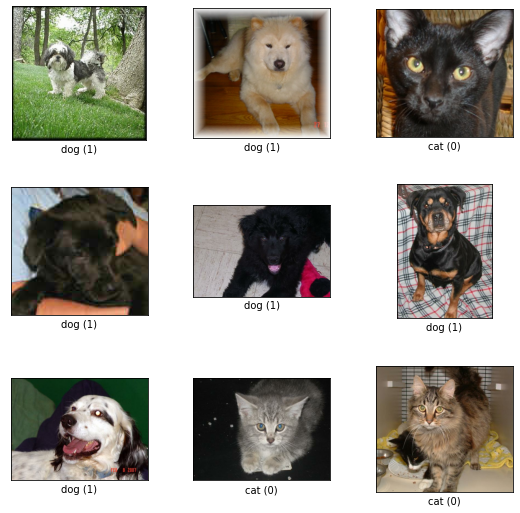

In [13]:
fig = tfds.show_examples(ds_train, ds_info)

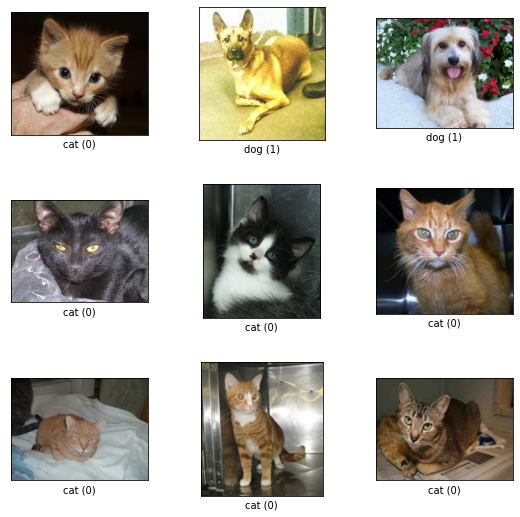

In [14]:
fig = tfds.show_examples(ds_test, ds_info)

### 입력  데이터 정규화

In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Step 5. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [17]:
BATCH_SIZE = 16
EPOCH = 10

In [18]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test,batch_size=BATCH_SIZE)

## Ablation Study

### ResNet-34

In [19]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

In [20]:
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [21]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 310s 250ms/step - loss: 0.7696 - accuracy: 0.5614 - val_loss: 0.6983 - val_accuracy: 0.5356
Epoch 2/10
1163/1163 [==============================] - 274s 236ms/step - loss: 0.6690 - accuracy: 0.6100 - val_loss: 1.1927 - val_accuracy: 0.5198
Epoch 3/10
1163/1163 [==============================] - 275s 236ms/step - loss: 0.6290 - accuracy: 0.6520 - val_loss: 0.6146 - val_accuracy: 0.6871
Epoch 4/10
1163/1163 [==============================] - 275s 236ms/step - loss: 0.5891 - accuracy: 0.6925 - val_loss: 0.6509 - val_accuracy: 0.6214
Epoch 5/10
1163/1163 [==============================] - 275s 236ms/step - loss: 0.5577 - accuracy: 0.7163 - val_loss: 0.5461 - val_accuracy: 0.7312
Epoch 6/10
1163/1163 [==============================] - 275s 236ms/step - loss: 0.5174 - accuracy: 0.7500 - val_loss: 0.4693 - val_accuracy: 0.7798
Epoch 7/10
1163/1163 [==============================] - 275s 237ms/step - loss: 0.4447 - accuracy: 0.7952 - val_

In [22]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('./history/history_resnet_34.csv', index=False)

#### ResNet-50

In [23]:
resnet_50 = build_resnet(input_shape=(224,224,3),
                        num_classes=1,
                        is_50=True,
                        activation='sigmoid')

In [24]:
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

In [25]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 279s 211ms/step - loss: 0.8604 - accuracy: 0.5731 - val_loss: 0.6849 - val_accuracy: 0.5874
Epoch 2/10
1163/1163 [==============================] - 207s 178ms/step - loss: 0.6237 - accuracy: 0.6544 - val_loss: 0.6204 - val_accuracy: 0.6706
Epoch 3/10
1163/1163 [==============================] - 208s 179ms/step - loss: 0.6406 - accuracy: 0.6329 - val_loss: 0.6929 - val_accuracy: 0.5891
Epoch 4/10
1163/1163 [==============================] - 208s 179ms/step - loss: 0.6232 - accuracy: 0.6568 - val_loss: 0.6498 - val_accuracy: 0.6482
Epoch 5/10
1163/1163 [==============================] - 208s 179ms/step - loss: 0.5721 - accuracy: 0.7070 - val_loss: 1.0646 - val_accuracy: 0.5617
Epoch 6/10
1163/1163 [==============================] - 208s 179ms/step - loss: 0.5330 - accuracy: 0.7361 - val_loss: 0.9145 - val_accuracy: 0.6372
Epoch 7/10
1163/1163 [==============================] - 208s 179ms/step - loss: 0.5168 - accuracy: 0.7448 - val_

In [26]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
})
df_resnet_50.to_csv('./history/history_resnet_50.csv', index=False)

#### Plain-34

In [27]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [28]:
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

In [29]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 269s 227ms/step - loss: 0.7099 - accuracy: 0.5075 - val_loss: 0.9140 - val_accuracy: 0.4912
Epoch 2/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.6928 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5546
Epoch 3/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.6938 - accuracy: 0.5241 - val_loss: 1.8736 - val_accuracy: 0.4834
Epoch 4/10
1163/1163 [==============================] - 262s 226ms/step - loss: 0.6944 - accuracy: 0.5208 - val_loss: 0.6917 - val_accuracy: 0.5233
Epoch 5/10
1163/1163 [==============================] - 262s 225ms/step - loss: 0.6934 - accuracy: 0.5210 - val_loss: 0.7009 - val_accuracy: 0.4901
Epoch 6/10
1163/1163 [==============================] - 262s 226ms/step - loss: 0.6929 - accuracy: 0.5269 - val_loss: 0.6871 - val_accuracy: 0.5539
Epoch 7/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.6903 - accuracy: 0.5324 - val_

In [30]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('./history/history_plain_34.csv', index=False)

#### Plain-50

In [31]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [32]:
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

In [33]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 429s 348ms/step - loss: 0.7356 - accuracy: 0.5091 - val_loss: 0.7849 - val_accuracy: 0.5593
Epoch 2/10
1163/1163 [==============================] - 414s 356ms/step - loss: 0.6930 - accuracy: 0.5291 - val_loss: 0.7004 - val_accuracy: 0.4940
Epoch 3/10
1163/1163 [==============================] - 398s 342ms/step - loss: 0.6964 - accuracy: 0.5017 - val_loss: 0.6953 - val_accuracy: 0.5017
Epoch 4/10
1163/1163 [==============================] - 397s 342ms/step - loss: 0.6982 - accuracy: 0.4990 - val_loss: 0.7056 - val_accuracy: 0.4814
Epoch 5/10
1163/1163 [==============================] - 397s 341ms/step - loss: 0.6975 - accuracy: 0.5177 - val_loss: 0.6933 - val_accuracy: 0.5002
Epoch 6/10
1163/1163 [==============================] - 397s 341ms/step - loss: 0.6992 - accuracy: 0.5021 - val_loss: 0.7757 - val_accuracy: 0.4909
Epoch 7/10
1163/1163 [==============================] - 397s 341ms/step - loss: 0.6958 - accuracy: 0.5039 - val_

In [34]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('./data/history_plain_50.csv', index=False)

### 시각화

In [35]:
history_resnet_34 = pd.read_csv('./data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('./data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('./data/history_plain_34.csv')
history_plain_50 = pd.read_csv('./data/history_plain_50.csv')

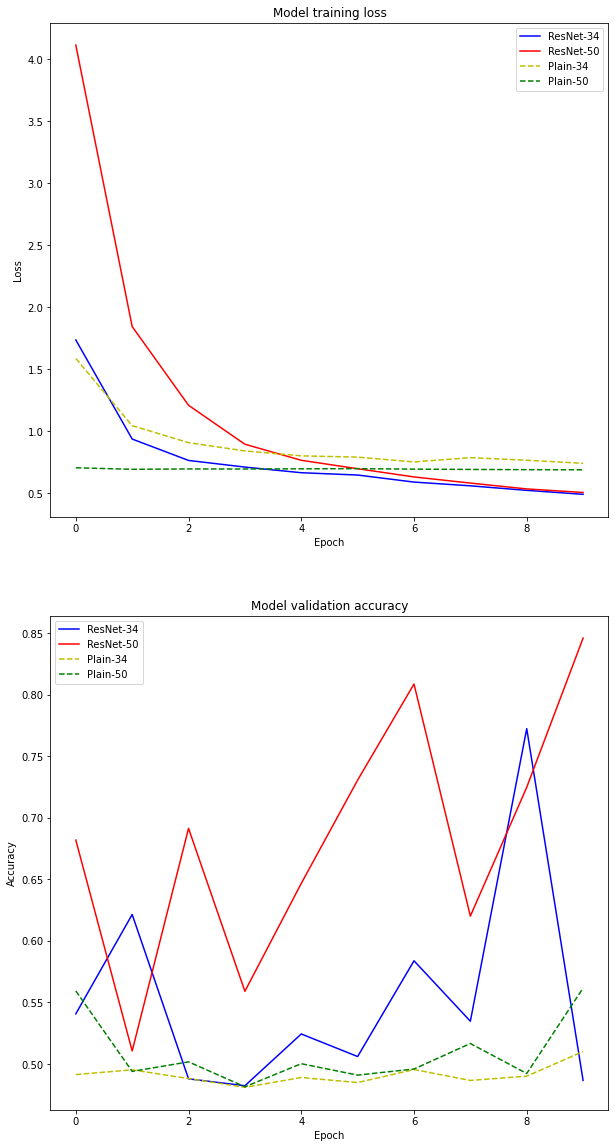

In [45]:
# 전체 비교
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'y', linestyle='dashed')
plt.plot(history_plain_50['train_loss'], 'g', linestyle='dashed')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'y', linestyle='dashed')
plt.plot(history_plain_50['val_acc'], 'g', linestyle='dashed')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')

plt.show()

### 회고 정리

ResNet의 핵심은 기존 네트워크와 달리 epoch이 늘어나도 loss가 높아지는 것이 아니라 낮아지고 accuracy 또한 더 좋은 값을 갖게 되는 것입니다. 한 가지 의문인 것은 왜 loss는 계속 감소를 하고 있는데 accuracy는 증가하는 경우도 있고 감소하는 경우도 있는 것이 의문입니다.

이 의문의 해결은 사람들은 흔히 loss와 accuracy가 엄청난 상관관계가 있을 거라고 생각하지만 실제로는 전혀 상관이 없습니다

정확도(Accuracy)는 전체 데이터에 대한 예측 오류의 수로 볼 수 있습니다. 예를 들어, 전체 데이터 중에서 몇 개를 맞췄는가이다. 100개 중 97개를 맞췄다면 accuracy는 97%이다.

손실(Loss)은 실제 정답과 모델이 예측 한 값 사이의 차이(거리 또는 오차)이다. 즉, 손실이 클수록 데이터에 대한 오류도 커지기에  틀리게 예측한 경우 얼마나 오류를 범했는가로 볼 수 있다.

그러므로 2개의 모델이 100개 중 97개를 똑같이 맞춰도 둘의 오차는 다를 수 있다.

1 Epoch 당 걸리는 시간이 생각보다 길었기 때문에 파라미터 설정에 대한 고민을 했습니다. 왜냐하면. 너무 작으면 accuracy에 수렴하지 못하고 너무  크면 overfitting가 되기 때문에 적당한 epoch고민을 하다가 epoch =10을 잡게 되었습니다. 


이것을 기준으로 실험의 경향성을 파악해보자면 실험결과를 바탕으로 분석이 된 것은

ResNet 50은 짝수일 때 더 좋은 정확성을 갖고 ResNet-34는 홀수일 때 더 좋은 정확성을 갖는 것입니다.

